In [285]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv


In [286]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
import plotly
import bokeh
import seaborn
from keras.utils import to_categorical

warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [287]:
train_original = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test_original = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

In [288]:
# label encoding the data 
from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder() 
  
train_original['sentiment'] = le.fit_transform(train_original['sentiment']) 
test_original['sentiment'] = le.fit_transform(test_original['sentiment']) 

In [289]:
train_original

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,1
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,2
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,1
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,0
4,bf7473b12d,haha better drunken tweeting you mean?,better,2
...,...,...,...,...
27481,3dbae74fcd,"I want to go to VP, but no one is willing to c...","I want to go to VP, but no one is willing to c...",1
27482,63147b35cb,"Wah, why are you sad?","Wah, why are you sad?",1
27483,bdb196a09f,playing sudoku while mommy makes me breakfast ...,playing sudoku while mommy makes me breakfast ...,1
27484,18c2a1e98e,see u bye see u! i love the hot30,i love,2


In [290]:
from numpy import array
sentiment_train_values = to_categorical(train_original['sentiment'].values, 3)
sentiment_test_values = to_categorical(test_original['sentiment'].values, 3)

sentiment_train_hot_encoded = pd.DataFrame(sentiment_train_values)
sentiment_test_hot_encoded = pd.DataFrame(sentiment_test_values)

In [291]:
train_original = train_original.join(sentiment_train_hot_encoded)
test_original = test_original.join(sentiment_test_hot_encoded)

In [292]:
train_original.columns=['textID','text','selected_text','sentiment','negative','neutral','positive']
test_original.columns=['textID','text','sentiment','negative','neutral','positive']

In [293]:
# a method to remove unwanted patterns in the text
def remove_pattern(text, pattern):
    text = re.sub(r'http\S+', '', str(text), flags=re.MULTILINE)
        
    return text  

In [294]:
# remove URLs
train_original['clean_text'] = ""
test_original['clean_text'] = ""


for i in range(train_original.shape[0]):  
    train_original['clean_text'][i] = remove_pattern(train_original['text'][i], "http\S+").lower()
for i in range(test_original.shape[0]):  
    test_original['clean_text'][i] = remove_pattern(test_original['text'][i], "http\S+").lower()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [295]:
# Remove Punctuations, Numbers, and Special Characters
train_original['clean_text'] = train_original['clean_text'].str.replace("[^a-zA-Z#]", " ")
test_original['clean_text'] = test_original['clean_text'].str.replace("[^a-zA-Z#]", " ")

In [296]:
# remove short words (length < 3)
train_original['clean_text'] = train_original['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
test_original['clean_text'] = test_original['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [297]:
# tokenizing, removing stop words, lemmatizing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def tokenizer(text):
    tokens = word_tokenize(text)
    return tokens

def stop_words_remover(tokens):
    cleaned_words = []
    stop_words = stopwords.words('english')
    for token in tokens:
        if (token in stop_words)or(token == " "):
            continue
        
        else:
            cleaned_words.append(token)
    return cleaned_words

def lemmatizer(cleaned_words):
    lemmatized_tokens = []
    
    for token in cleaned_words:
        lemma_token = WordNetLemmatizer().lemmatize(token)
        lemmatized_tokens.append(lemma_token)
        
    return lemmatized_tokens

def clean_sentence(clean_tokens):
    return ' '.join(clean_tokens)

def text_cleaner(text_column):
    clean_text = []
    stop_words = stopwords.words('english') 
    for text in text_column:
        token = tokenizer(text)
        no_stopwords_tokens = stop_words_remover(token)
        clean_tokens = lemmatizer(no_stopwords_tokens)
        clean_strings = clean_sentence(clean_tokens)
        clean_text.append(clean_strings)
    return clean_text


In [298]:
train_original['clean_text'] = text_cleaner(train_original['clean_text'])

In [306]:
from wordcloud import WordCloud
def wordClodDisplay(selected_words,title_name):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(selected_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title_name)
    plt.axis('off')
    plt.show() 

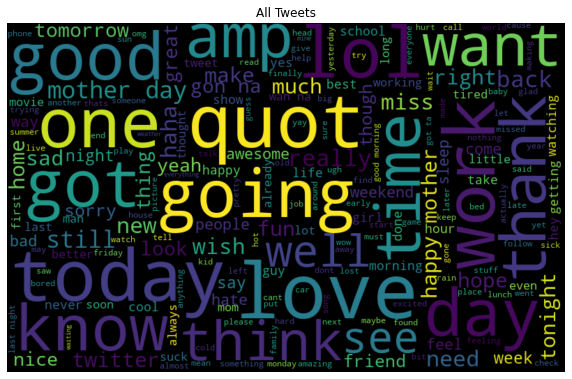

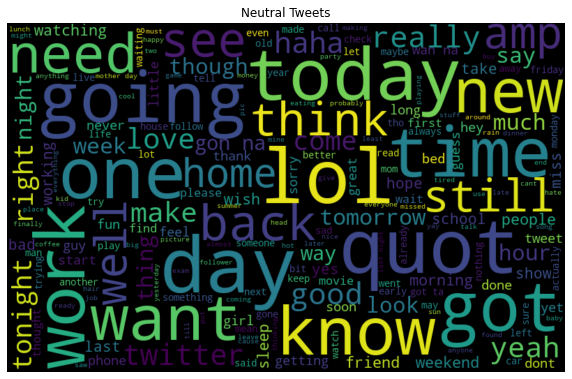

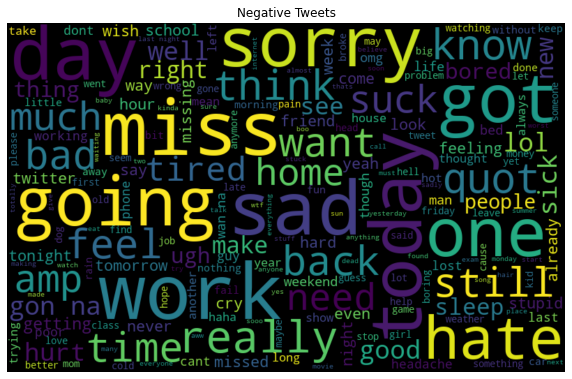

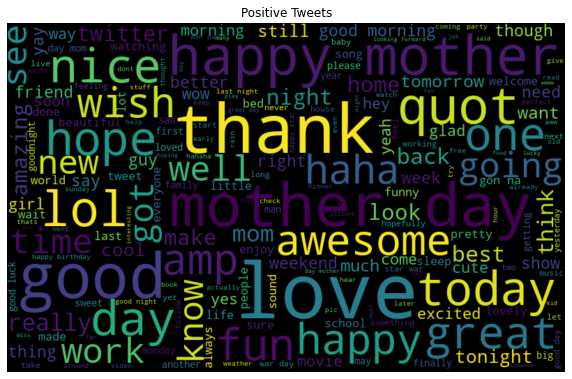

In [307]:
# show most frequent words in all tweets
all_words = ' '.join([text for text in train_original['clean_text']])
wordClodDisplay(all_words,'All Tweets')

# show most frequent words in neutral tweets
neu_words =' '.join([text for text in train_original['clean_text'][train_original['neutral'] == 1]])
wordClodDisplay(neu_words, 'Neutral Tweets')

# show most frequent words in negative tweets
neg_words =' '.join([text for text in train_original['clean_text'][train_original['negative'] == 1]])
wordClodDisplay(neg_words, 'Negative Tweets')

# show most frequent words in positive tweets
pos_words =' '.join([text for text in train_original['clean_text'][train_original['positive'] == 1]])
wordClodDisplay(pos_words, 'Positive Tweets')

In [308]:
train_original

,textID,text,selected_text,sentiment,negative,neutral,positive,clean_text
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,1,0.0,1.0,0.0,spent entire morning meeting vendor bos happy ...
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,2,0.0,0.0,1.0,good idea putting ice cream
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,1,0.0,1.0,0.0,say good say bad afternoon
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,0,1.0,0.0,0.0,dont think vote anymore tried
4,bf7473b12d,haha better drunken tweeting you mean?,better,2,0.0,0.0,1.0,haha better drunken tweeting mean
...,...,...,...,...,...,...,...,...
27481,3dbae74fcd,"I want to go to VP, but no one is willing to c...","I want to go to VP, but no one is willing to c...",1,0.0,1.0,0.0,want one willing come
27482,63147b35cb,"Wah, why are you sad?","Wah, why are you sad?",1,0.0,1.0,0.0,wah sad
27483,bdb196a09f,playing sudoku while mommy makes me breakfast ...,playing sudoku while mommy makes me breakfast ...,1,0.0,1.0,0.0,playing sudoku mommy make breakfast amp lunch
27484,18c2a1e98e,see u bye see u! i love the hot30,i love,2,0.0,0.0,1.0,see bye see love hot
